# Variational Autoencoder for Topology Optimization

## Introduction and Theory

Variational Autoencoders (VAEs) are powerful generative models that learn to encode data into a lower-dimensional latent space and then reconstruct it. In the context of topology optimization, we're particularly interested in learning meaningful representations of structural designs that can be manipulated and interpolated.

The key idea behind VAEs is based on the following probability model:

$p(x|z) = \mathcal{N}(f_\theta(z), \sigma^2I)$  (decoder/likelihood)

$p(z) = \mathcal{N}(0, I)$           (prior)

$q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma_\phi(x)^2)$  (encoder/approximate posterior)

where:
- $x$ is our input topology design
- $z$ is the latent space variable
- $\theta$ and $\phi$ are the neural network parameters
- $f_\theta$ represents our decoder network
- $\mu_\phi$ and $\sigma_\phi$ are outputs of our encoder network

We first import the required library. We will use torch for the Neural Network definition and training.

We first import the required library. We will use torch for the Neural Network definition and training.## Required Libraries Setup

First, install the required Python packages. You can use pip to install them:

```bash
pip install torch torchvision
pip install numpy matplotlib
pip install scikit-learn


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

## Data Loading and Dataset Organization

The data loading and organization pipeline consists of three main components:

### Custom Dataset Class

The `TopologyDataset` class inherits from PyTorch's Dataset class and handles the organization of our topology optimization data. It reformats our images into the proper shape for the vae network (batch_size, channels, height, width) and converts both images and labels to PyTorch tensors.

### Grayscale Conversion

The `rgb2gray` function handles the conversion of RGB images to grayscale using standard luminance weights. This conversion preserves the important structural information while reducing the dimensionality of our data. The weights (0.2989, 0.5870, 0.1140) correspond to the human perception of color intensity for red, green, and blue channels respectively.

### Data Loading Function

The `load_data` function implements the main data loading pipeline. It reads images from the specified directory, processes them (either converting from RGB to grayscale or normalizing existing grayscale images), and extracts corresponding labels from the filenames. Labels in our case represent two parameters encoded in the filename structure. The function handles both RGB and grayscale inputs, normalizes all pixel values to the range [0,1], and returns numpy arrays ready for dataset creation.

In [10]:
class TopologyDataset(Dataset):
    """Custom Dataset for topology optimization images"""
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def rgb2gray(rgb):
    """Convert RGB image to grayscale and normalize"""
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])/255.0

def load_data(data_path='../../Dataset_TopOpt/images_topopt_2/'):
    """Load and preprocess topology optimization images"""
    file_names = glob.glob(data_path + '*.jpg')
    images = []
    labels = []
    
    # Load images and labels
    for file_name in file_names:
        img = mpimg.imread(file_name)
        images.append(rgb2gray(img))
        
        # Extract labels from filename
        tmp = file_name.split('_')
        labels.append([int(tmp[-2]), int(tmp[-1][:-4])])
    
    # Convert to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)
    
    # Flatten images
    n_pixels = np.prod(images.shape[1:])
    images = images.reshape((len(images), n_pixels))
    
    return images, labels

### Let's visualize the data!

43974
2448


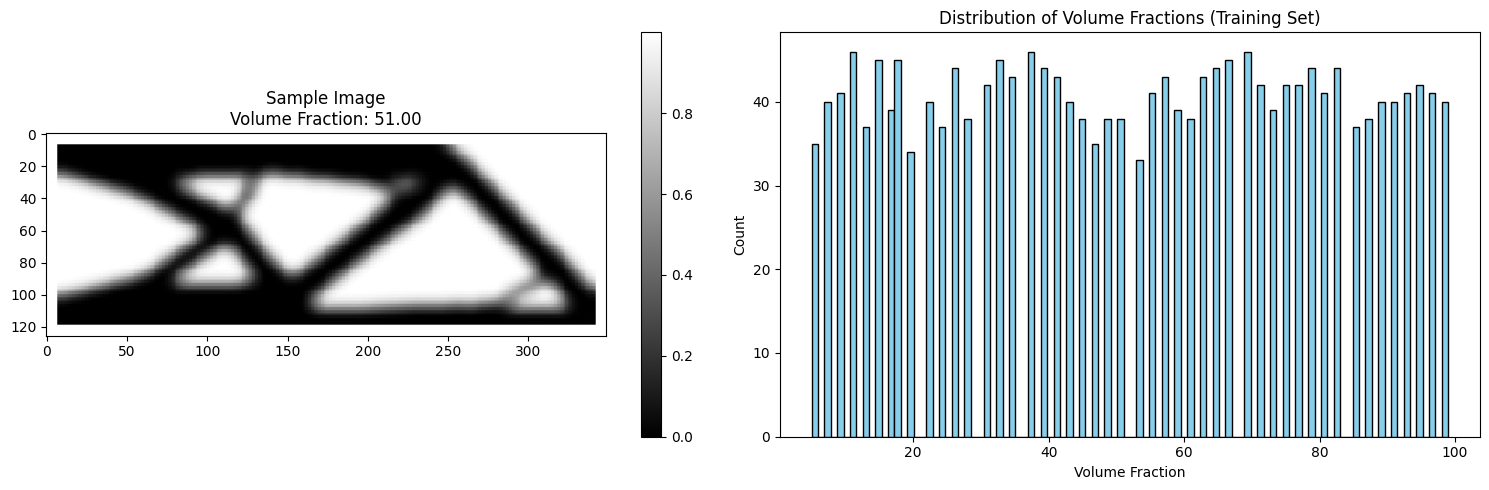

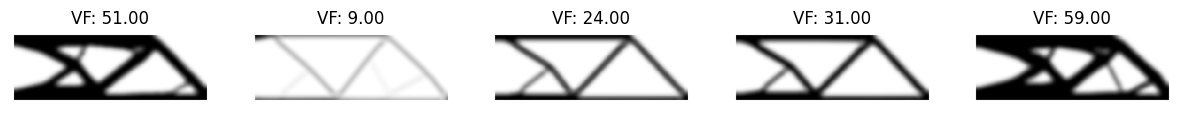


Dataset Statistics:
Training set size: 1958
Test set size: 490

Volume Fraction Statistics:
Mean: 52.02
Std: 27.77
Min: 5.00
Max: 99.00


In [11]:
# Load and prepare data
images, labels = load_data()
x_train, x_test, y_train, y_test = train_test_split(
    images, labels[:, 0], test_size=0.2, random_state=42
)


# Create a figure with multiple subplots
plt.figure(figsize=(15, 5))

# 1. Sample Image Display
plt.subplot(1, 2, 1)
# Reshape first training image back to original dimensions
sample_img = x_train[0].reshape(126, 349)  # Adjust dimensions based on your data
plt.imshow(sample_img, cmap='gray')
plt.title(f'Sample Image\nVolume Fraction: {y_train[0]:.2f}')
plt.colorbar()

# 2. Distribution of Volume Fractions
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Volume Fractions (Training Set)')
plt.xlabel('Volume Fraction')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 3. Grid of Sample Images
plt.figure(figsize=(15, 5))
n_samples = 5
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    sample_idx = i * len(x_train) // n_samples
    img = x_train[sample_idx].reshape(126, 349)  # Adjust dimensions based on your data
    plt.imshow(img, cmap='gray')
    plt.title(f'VF: {y_train[sample_idx]:.2f}')
    plt.axis('off')
plt.show()



# Print some basic statistics
print("\nDataset Statistics:")
print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")
print(f"\nVolume Fraction Statistics:")
print(f"Mean: {np.mean(y_train):.2f}")
print(f"Std: {np.std(y_train):.2f}")
print(f"Min: {np.min(y_train):.2f}")
print(f"Max: {np.max(y_train):.2f}")

### We standardize the data before feeding to our model

In [12]:
# Standardize y values (volume fractions)
y_mean = y_train.mean()
y_std = y_train.std()
y_train_standardized = (y_train - y_mean) / y_std
y_test_standardized = (y_test - y_mean) / y_std

# Reshape y to (num_samples, 1)
y_train_standardized = y_train_standardized.reshape(-1, 1)
y_test_standardized = y_test_standardized.reshape(-1, 1)

# Create datasets and dataloaders with standardized y values
train_dataset = TopologyDataset(x_train, y_train_standardized)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Print shapes to verify
print("X train shape:", x_train.shape)
print("Y train shape:", y_train_standardized.shape)

# Print standardization parameters (save these for later use in generation)
print("\nStandardization parameters:")
print(f"Mean: {y_mean:.4f}")
print(f"Std: {y_std:.4f}")

X train shape: (1958, 43974)
Y train shape: (1958, 1)

Standardization parameters:
Mean: 52.0163
Std: 27.7679


## Variational Autoencoder (VAE)

This implements a standard VAE with conditional input, using fully connected layers. The architecture follows the basic VAE framework with encoder, latent space sampling, and decoder.

#### 1. Encoder Network
- Input: Flattened image concatenated with condition
- Maps input to latent space parameters:
 - $\mu_\phi(x,c)$: mean vector
 - $\log \sigma^2_\phi(x,c)$: log variance vector

#### 2. Latent Space Sampling
Uses the reparameterization trick:
- $z = \mu + \sigma \odot \epsilon$, where $\epsilon \sim \mathcal{N}(0,I)$
- Approximates sampling from $q_\phi(z|x,c) = \mathcal{N}(\mu_\phi(x,c), \sigma^2_\phi(x,c))$

#### 3. Decoder Network
- Input: Sampled latent vector concatenated with condition
- Reconstructs input from latent representation: $p_\theta(x|z,c)$


In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2, hidden_dim=256):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim    
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for condition
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim),  # +1 for condition
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x, c):
        """Encode input to latent space parameters"""
        # Concatenate input and condition
        x = torch.cat([x, c], dim=1)
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_var(x)
    
    def reparameterize(self, mu, log_var):
        """Sample from latent space using reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        """Decode latent vector to original space"""
        # Concatenate latent vector and condition
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)
    
    def forward(self, x, c):
        """Forward pass through the VAE"""
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var
    
#Print the model architecture summary
model = VAE(input_dim=x_train.shape[1])
print(model)


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=43975, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_var): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=43974, bias=True)
    (5): Sigmoid()
  )
)


## Training the Vanilla VAE

The training process optimizes the Evidence Lower BOund (ELBO), which consists of two terms:

### Loss Components

1. **Reconstruction Loss (Binary Cross Entropy)**
  $\mathcal{L}_{BCE} = -\sum_i [x_i \log(\hat{x}_i) + (1-x_i)\log(1-\hat{x}_i)]$
  - Measures how well the model reconstructs the input
 
2. **KL Divergence Loss**
  $\mathcal{L}_{KL} = -\frac{1}{2}\sum_i (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$
  - Regularizes the latent space distribution
  - Pushes $q_\phi(z|x)$ towards prior $p(z) = \mathcal{N}(0,I)$

### ELBO Formulation

The Evidence Lower BOund being maximized is:
$\mathcal{L}_{ELBO} = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - KL(q_\phi(z|x)||p(z))$


In [15]:
def train_vae(model, train_loader, optimizer, device, epochs=5):
    """Train the VAE model"""
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_bce = 0
        total_kld = 0
        
        for batch_idx, (data, conditions) in enumerate(train_loader):
            data = data.to(device)
            conditions = conditions.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data, conditions)
            
            # Calculate both losses separately
            bce = F.binary_cross_entropy(recon_batch, data, reduction='sum')
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = bce + kld
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()
        
        # Calculate averages
        n_samples = len(train_loader.dataset)
        avg_loss = total_loss / n_samples
        avg_bce = total_bce / n_samples
        avg_kld = total_kld / n_samples
        
        # Print epoch statistics
        print(f'\nEpoch {epoch+1}:')
        print(f'  Average loss = {avg_loss:.4f}')
        print(f'  Reconstruction (BCE) = {avg_bce:.4f}')
        print(f'  KL Divergence = {avg_kld:.4f}')
        print('-' * 50)
        



# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = VAE(input_dim=x_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
train_vae(model, train_loader, optimizer, device, epochs= 5)

/home/dmsm/gi.catalani/miniforge3/envs/py311_gdl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch 1:
  Average loss = 9274.6328
  Reconstruction (BCE) = 9142.0160
  KL Divergence = 132.6168
--------------------------------------------------

Epoch 2:
  Average loss = 7344.9301
  Reconstruction (BCE) = 7279.2534
  KL Divergence = 65.6767
--------------------------------------------------

Epoch 3:
  Average loss = 7075.0581
  Reconstruction (BCE) = 7025.7316
  KL Divergence = 49.3266
--------------------------------------------------

Epoch 4:
  Average loss = 7014.1823
  Reconstruction (BCE) = 6975.3930
  KL Divergence = 38.7893
--------------------------------------------------

Epoch 5:
  Average loss = 7105.1923
  Reconstruction (BCE) = 7066.0472
  KL Divergence = 39.1451
--------------------------------------------------


## Analysis and Generation with VAE

### 1. Latent Space Visualization
`visualize_latent_space()`
- Maps all designs to 2D latent space using encoder
- Each point represents $\mu$ of $q_\phi(z|x)$ for an input

### 2. Design Generation
`generate_topology()`
- Creates new designs from latent vectors
- Can either:
 - Sample from prior: $z \sim \mathcal{N}(0,I)$
 - Use specified latent vector $z$
- Controls volume fraction through condition parameter

### 3. Latent Space Exploration
`plot_latent_space_sweep()`
- Creates grid of designs by: Systematically sampling latent space points


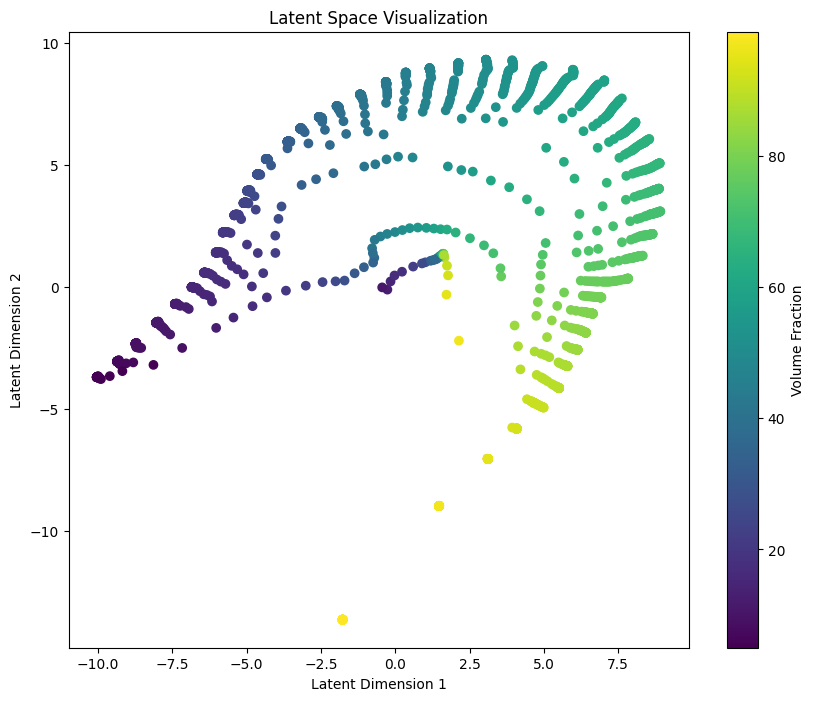

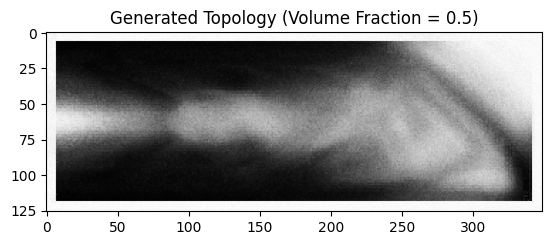

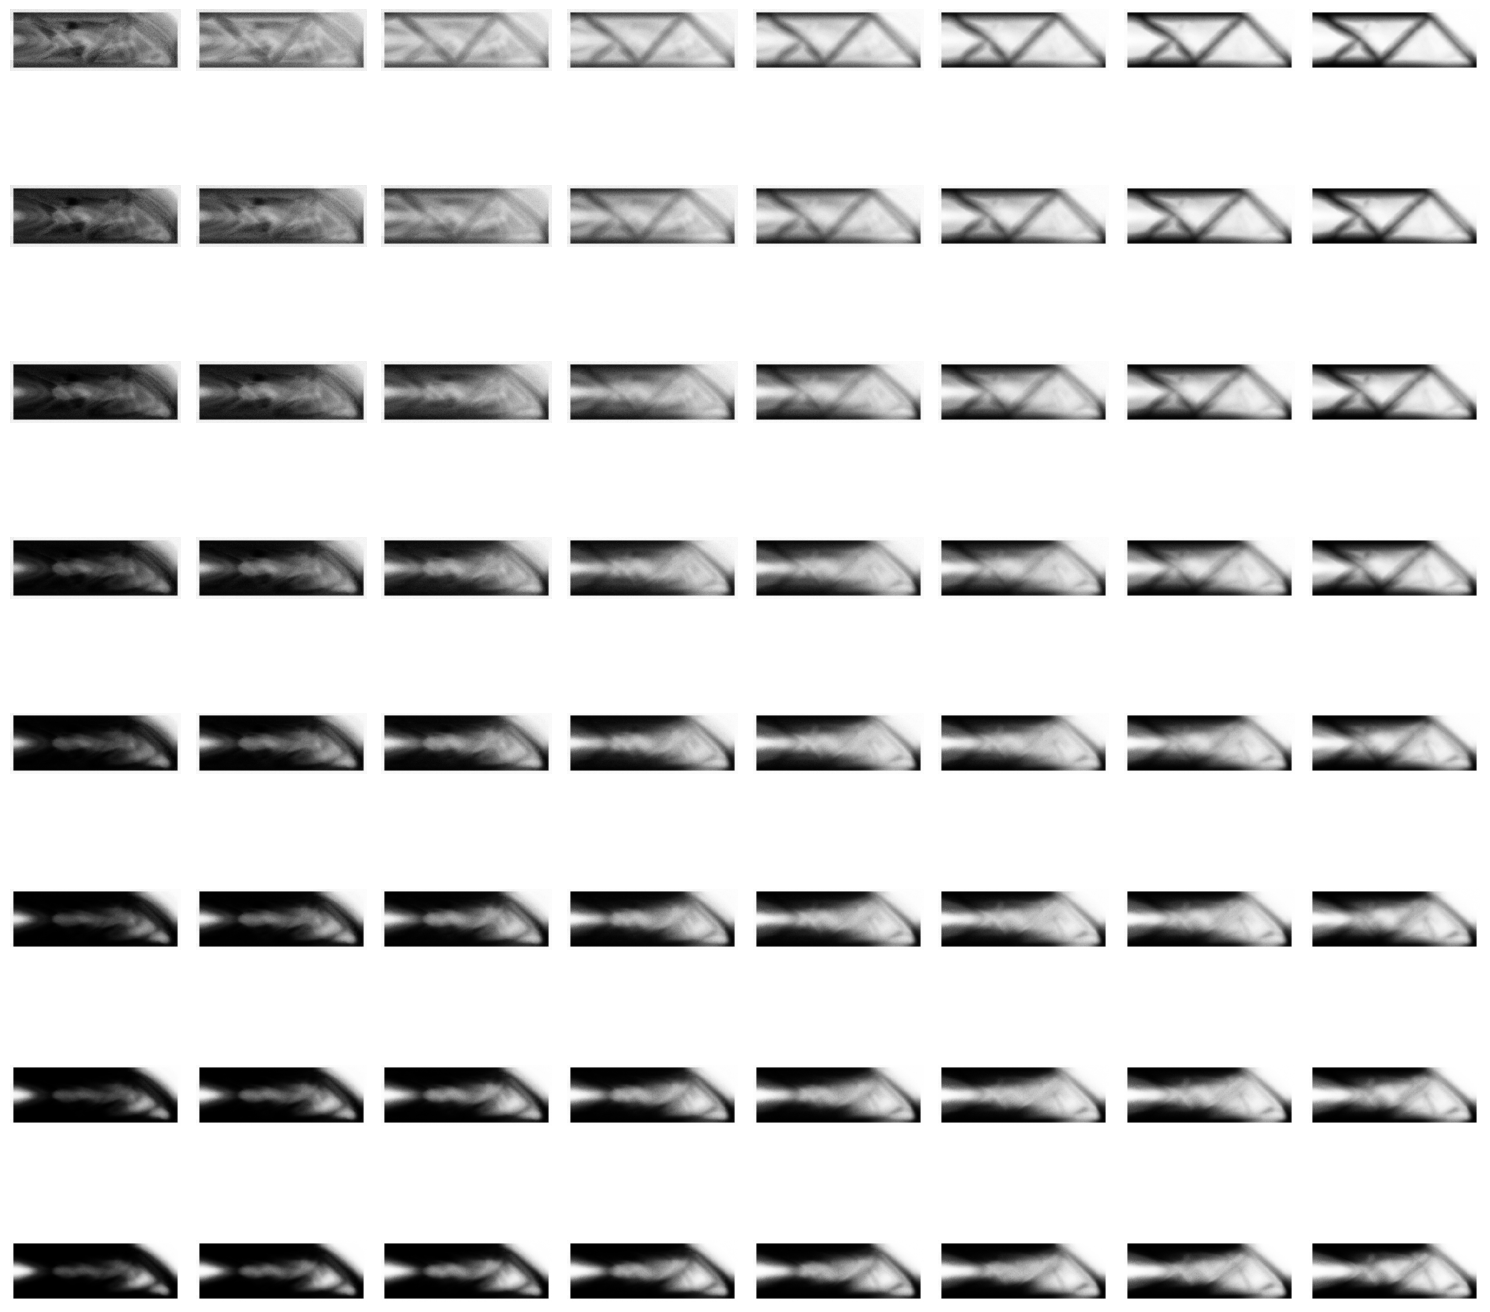

In [17]:
def visualize_latent_space(model, dataset, device):
    """Visualize the latent space encodings"""
    model.eval()
    encodings = []
    labels = []
    
    with torch.no_grad():
        for data, condition in dataset:
            data = data.unsqueeze(0).to(device)
            condition = condition.unsqueeze(0).to(device)
            mu, _ = model.encode(data, condition)
            encodings.append(mu.cpu().numpy())
            labels.append(condition.cpu().numpy()*y_std + y_mean)
    
    encodings = np.vstack(encodings)
    labels = np.vstack(labels)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encodings[:, 0], encodings[:, 1], 
                         c=labels[:, 0], cmap='viridis')
    plt.colorbar(scatter, label='Volume Fraction')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.show()

def generate_topology(model, condition, z=None, device='cpu'):
    """Generate topology design for given parameters"""
    model.eval()
    with torch.no_grad():
        if z is None:
            z = torch.randn(1, model.latent_dim).to(device)
        condition = torch.tensor([[condition]]).float().to(device)
        topology = model.decode(z, condition)
        return topology.cpu().numpy().reshape(126, 349)

def plot_latent_space_sweep(model, condition, sides=8, max_z=2):
    """Generate grid of topologies by sweeping through latent space"""
    plt.figure(figsize=(15, 15))
    for i in range(sides):
        for j in range(sides):
            z1 = (((i / (sides-1)) * max_z)*2) - max_z
            z2 = (((j / (sides-1)) * max_z)*2) - max_z
            
            z = torch.tensor([[z1, z2]]).float()
            topology = generate_topology(model.to('cpu'), condition, z)
            
            plt.subplot(sides, sides, i*sides + j + 1)
            plt.imshow(topology, cmap='gray')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Visualize latent space
visualize_latent_space(model, train_dataset, device)

# Generate single topology
topology = generate_topology(model, condition=0.5, device=device)
plt.imshow(topology, cmap='gray')
plt.title('Generated Topology (Volume Fraction = 0.5)')
plt.show()

# Generate grid of topologies
plot_latent_space_sweep(model, condition=0.5)